# Introduction to Transfer Learning

Transfer learning is a type of machine learning technique that takes advantage of knowledge gained from solving a problem in one domain, and transferring it to another in order to optimize accuracy and speed.
   
A common application of transfer learning is using the features learned by large convolutional neural networks as additional information that we can transfer to another domain. Models like VGG16 have learned generalized features seen in the 1000 classes of ImageNet, and these features can be used for a more specialized task.

![](images/transfer.png)

One of the biggest benefits and motivations of transfer learning is to take advantage of small datasets for domains and tasks with little data available.

![](images/improvements.png)

There are typically two approaches in applying transfer learning to deep learning:
- Develop Model (making your own model with similar data to your actual task, but with much more data)
- Pre-Trained Model (taking an already existing model and used as a starting point for your actual task). After reviewing some concepts we will look at two demos using pre-trained models

## History

Applying tranfer learning to machine learning originated in a NIPS-95 (Conference on Neural Information Processing Systems) workshop on "Learning to Learn", which focused on machine-learning methods that retain and reuse previously learned knowledge.

Since then transfer learning has appeared in different contexts under many different names such as:
- Learning to learn
- Life-long learning
- Knowledge transfer
- Inductive transfer
- Multi-task learning
- Knowledge consolidation
- Context-sensitive learning
- Knowledge-based inductive bias
- Meta learning
- Incremental/cumulative learning
    
Multitask learning is closely related, and tries to learn multiple tasks at once. We will cover it later in the semester.

In 2005, DARPA sought to apply transfer learning with the intent of extracting the knowledge learned from a source task to apply to a target task, without necessary regard for the source task. This differed from the goal of multitask learning in which all tasks are equally important.

Today with the abundance of pretrained models available, transfer learning is very prominent in the fields of machine learning and data mining.


## Definition

A domain $\mathcal{D}$ consists of a feature space $\mathcal{X}$ and marginal probability distribution $P(X)$ over the feature space, where $X = x_1, ..., x_n \in \mathcal{X}$.

Given a domain, $\mathcal{D} = \left\{\mathcal{X}, P(X)\right\}$, a task $\mathcal{T}$ consists of a label space $\mathcal{Y}$ and a conditional probability distribution $P(Y|X)$ learned from the training data.

Given a source domain $\mathcal{D}_S$, a corresponding source task $\mathcal{T}_S$, as well as a target domain $\mathcal{D}_T$ and a target task $\mathcal{T}_T$, the objective of transfer learning is to learn the target conditional probability distribution $P(Y_T|X_T)$ in $\mathcal{D_T}$ with information gained from $\mathcal{D}_S$ and $\mathcal{D}_T$ where $\mathcal{D}_S \neq \mathcal{D}_T$ or $\mathcal{T}_S \neq \mathcal{T}_T$.

## Settings and Approaches

Early approaches to transfer learning defined three different settings within transfer learning:
- Inductive - same domains, different tasks
- Unsupervised - different domains, different tasks
- Transductive - different domains, same tasks

Along with these settings are four different approaches that are be used in these settings:

- Instance-transfer - re-weight some labeled data in source domain for use in target domain
- Feature-representation transfer - find a feature representation that reduces the difference between the source and target domains
- Parameter-transfer - Discover shared parameters between domains
- Relation-knowledge transfer - Build mapping of relation knowledge between domains

The table below shows how these approaches can be used in different settings:

![](images/approaches.png)
(Sinno Jialin Pan and Qiang Yang, A Survey on Transfer Learning)

## Applications and Examples

### Spam Filtering
A transfer learning example in which the domains are the same, but tasks are different, would be a classifier to detect spam in email. A model could be trained on emails from multiple users. A new email user could then use this model to filter their own messages.

### Domain Adaptation
An example in which domains differ but tasks are the same would be a classifier to detect bicycles, but the target domain has very little data (bikes in the wild), and the source domain has a lot of data (bikes in the lab).

![](images/transfer_learning_bikes.png)
(Sun, B., Feng, J., & Saenko, K. (2016). Return of Frustratingly Easy Domain Adaptation)

### Pre-trained CNN features from large CNNs

Pre-trained CNN features are often used as a form of transfer learning in a variety of tasks such as image classification, object detection, style transfer and generative models. Large CNNs that have been trained on ImageNet learn the underlying structure of images, which is knowledge that can be transferred. A lot of recent research in computer vision and deep learning tend to use VGG16 or VGG19 as a base to extract features from the target domain.

#### Object Detection
State of the art object detection is done by YOLO, which pretrains with ImageNet, to learn knowledge from a classification task before training the model for object detection.

#### Style Transfer
Johnson et al's real time style transfer use the extracted features from VGG19 in the loss function used to train the style transformation network. The features can be used as statistics measuring the style and content of images.

#### Super Resolution
Another application of using VGG19 in a loss function is with super resolution. The loss is taken as the difference between the extracted features of the output image and the actual high resolution image. 

### Sentiment Analysis
Applications in NLP include learning from a large set of labeled reviews, and transferring to a model to analyze reviews for a new product.



# Demo: Cats or Dogs Classifier

Some code adapted from Francois Chollet:

- https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html
- http://nbviewer.jupyter.org/github/fchollet/deep-learning-with-python-notebooks/blob/master/5.3-using-a-pretrained-convnet.ipynb
- https://www.tensorflow.org/tutorials/images/data_augmentation

We will create a classifier to detect if a given image contains a cat xor a dog.

This classifier will be trained on features extracted from VGG16. We will then "fine tune" the last convolutional block of VGG, with our classifier on top using data augmentation.

Our training data consists of about 20,000 images (compared to ImageNet's 13M images), which we will see can still give us an impressive accuracy.



## Data and preprocessing
- You can also create your own scrubbed web dataset from Flickr (https://github.com/8000net/flicker-search-dl)
- We will resize the images to 150x150 and scale all RGB values to 0-1.

In [1]:
# watermark the notebook
import sys
import tensorflow.keras
import scipy as sp
import tensorflow as tf
import platform
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
import matplotlib.pyplot as plt

print(f"Python Platform: {platform.platform()}")
print(f"Tensor Flow Version: {tf.__version__}")
print(f"Keras Version: {tensorflow.keras.__version__}")
print()
print(f"Python {sys.version}")

gpus = tf.config.list_physical_devices('GPU')
print("GPU Resources Available:\n\t",gpus)

Python Platform: macOS-12.6.2-arm64-arm-64bit
Tensor Flow Version: 2.9.0
Keras Version: 2.9.0

Python 3.9.16 (main, Jan 11 2023, 10:02:19) 
[Clang 14.0.6 ]
GPU Resources Available:
	 [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [2]:
import os
from tensorflow.io import read_file, write_file
from tensorflow.image import decode_image

# you will need to dogs and cats dataset from microsoft
# https://www.microsoft.com/en-us/download/details.aspx?id=54765

should_rewrite_image = False # set to true if you are getting "Corrupt Data" error
num_skipped = 0
for folder_name in ("Cat", "Dog"):
    folder_path = os.path.join("data/cats_dogs", folder_name)
    for fname in os.listdir(folder_path):
        fpath = os.path.join(folder_path, fname)
        is_jfif = True
        should_remove = False
        
        with open(fpath, "rb") as fobj:
            is_jfif = tf.compat.as_bytes("JFIF") in fobj.peek(10)
            
        try:
            img = read_file(fpath)
            if not tf.io.is_jpeg(img):
                should_remove = True
                
            img = decode_image(img)

            if img.ndim != 3:
                should_remove = True

        except Exception as e:
            should_remove = True
        
        if (not is_jfif) or should_remove:
            num_skipped += 1
            # Delete corrupted image
            os.remove(fpath)
        elif should_rewrite_image:
            tmp = tf.io.encode_jpeg(img)
            write_file(fpath, tmp)

print("Deleted %d images" % num_skipped)

Metal device set to: Apple M1 Max


2023-01-24 23:21:26.636989: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-01-24 23:21:26.637105: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Deleted 0 images


In [3]:
# dimensions of our images.
img_width, img_height = 150, 150
batch_size = 64
data_dir = 'data/cats_dogs/'

train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)


        

Found 23385 files belonging to 2 classes.
Using 18708 files for training.
Found 23385 files belonging to 2 classes.
Using 4677 files for validation.


In [4]:
%matplotlib inline
# create two sequential models that simply rescale and augment the data

# By default, these operations will be on the same device
data_rescale = tf.keras.Sequential([
  layers.Rescaling(1./255)
], name='normalizer')


# WARNING: this will not run on an M1 Mac as of January 2023 
# Some are supported on newer M1 Macs, but then cause problems 
#. down the line for training convolution
# data_augmentation = tf.keras.Sequential([
#     # layers.RandomFlip('horizontal'), # not supported on M1
#     # layers.RandomHeight(0.2), # not supported on M1
#     # layers.RandomWidth(0.2), # not supported on M1
#     # layers.RandomZoom(0.2), # zoom in randomly, up to 30%, # not supported on M1
#     # layers.RandomRotation(0.2),
# ], name='augmentation')

# # give these 
# plt.figure(figsize=(10, 10))
# for images, _ in train_ds.take(1):
#     for i in range(9):

#         augmented_images = data_augmentation(images)
#         ax = plt.subplot(3, 3, i + 1)
#         plt.imshow(augmented_images[0].numpy().astype("uint8"))
#         plt.axis("off")

In [5]:

images = []
titles = []
i = 0
for image, labels in train_ds.take(4):
    print(image.shape)
    image = [x.numpy().astype("uint8") for x in image]
    images.extend(image)
    labels = ['Dog' if x==1 else 'Cat' for x in labels]
    #titles.append('Cat' if labels[0] == 1 else 'Dog')
    titles.extend(labels)
        
print(f'Found {len(images)} images to plot')

2023-01-24 23:22:16.868727: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


(64, 150, 150, 3)
(64, 150, 150, 3)
(64, 150, 150, 3)
(64, 150, 150, 3)
Found 256 images to plot


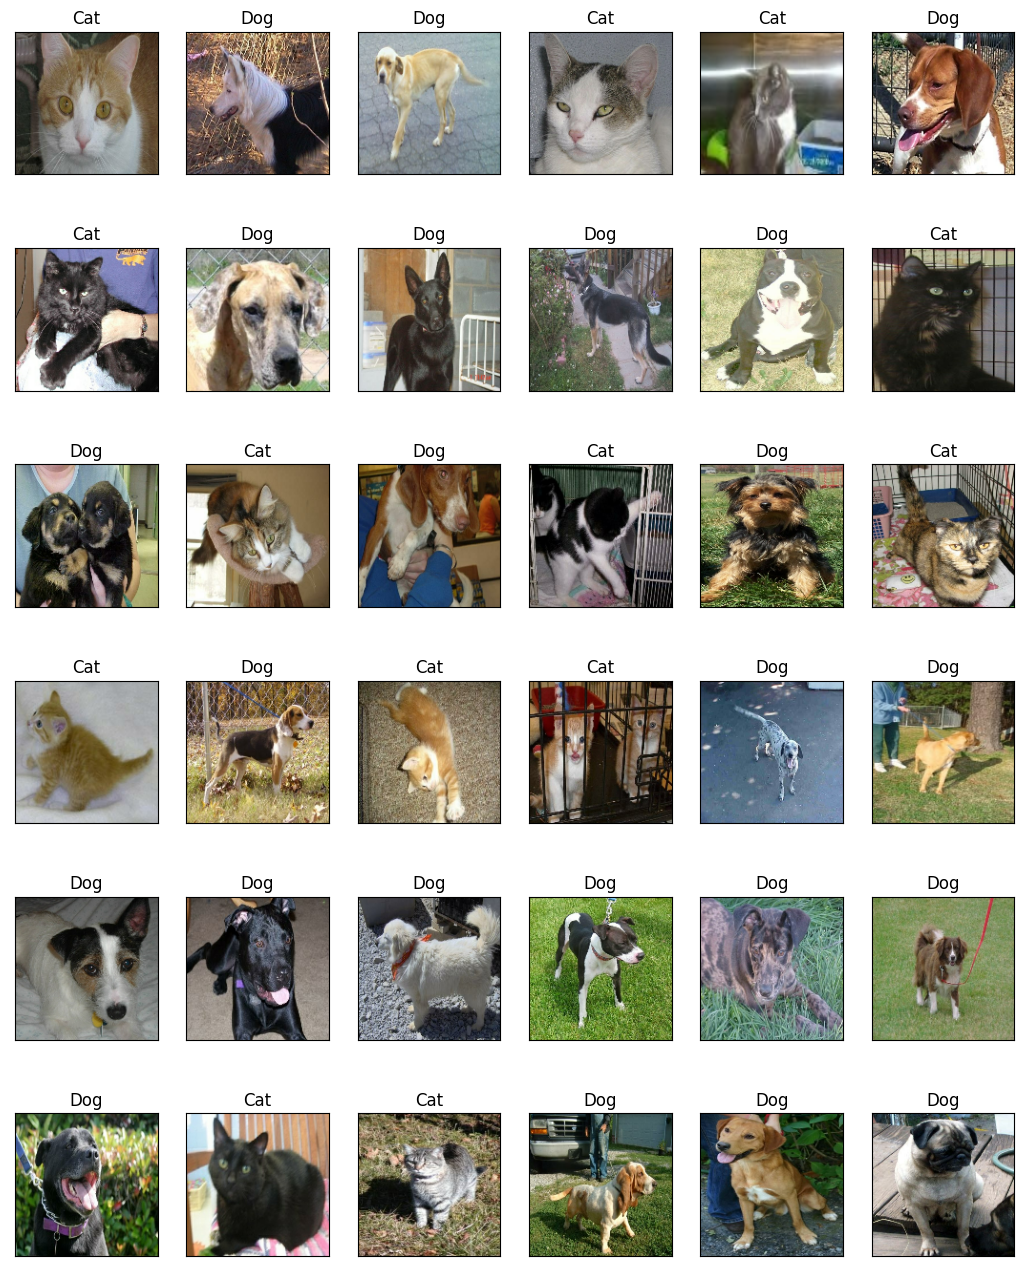

In [6]:
def plot_gallery(images, titles, n_row=3, n_col=6):
    """Helper function to plot a gallery of portraits"""
    plt.figure(figsize=(1.7 * n_col, 2.3 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(images[i])
        plt.title(titles[i], size=12)
        plt.xticks(())
        plt.yticks(())
        
plot_gallery(images, titles, n_row=6, n_col=6)

# Feature Extraction
- First we run all training and validation images through VGG16 with the classifier removed
  to extract the features and save them out
- We do this so that we can train the classifier with multiple epochs without re-extracting the features (takes ~3 min on Tesla P100 to extract the features of 2800 150x150 images)

In [7]:
from tensorflow.keras.applications import VGG16

# build the VGG16 network, leaving off the top classifier layer
# so we just get the features as output
print('Building VGG16...')
input_tensor = layers.Input(shape=(img_width, img_height, 3))
# here is where you can add in augmentation... 
# x = data_augmentation(input_tensor) # add in flips, scale, roatate, and everything else
x = data_rescale(input_tensor) # 1/255 from above
base_model = VGG16(weights='imagenet', include_top=False,
        input_tensor=x)


Building VGG16...


In [8]:
%%time
  
# Save bottleneck features from VGG
def save_bottleneck(ds, filename_addendum):
    bottleneck_features = []
    labels_train = []
    for data, label in ds:
        # loop through and get features and labels as lists
        bottleneck_features.extend(base_model.predict(data,verbose=0))
        labels_train.extend(label)

    # convert to numpy and save
    bottleneck_features = np.array(bottleneck_features)
    labels_train = np.array(labels_train)
    np.save(f'data/bottleneck_features_{filename_addendum}.npy', bottleneck_features)
    np.save(f'data/bottleneck_labels_{filename_addendum}.npy', labels_train)

# Save training features
print('Saving bottleneck features (train)...')
save_bottleneck(train_ds,'train')


# Save validation features
print('Saving bottleneck features (test)...')
save_bottleneck(val_ds,'test')

#TODO: I have like 6-8 corrupted JPEG files that are not getting found, why? 


Saving bottleneck features (train)...


2023-01-24 23:22:26.640258: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-01-24 23:23:04.357062: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Saving bottleneck features (test)...
CPU times: user 38.9 s, sys: 10.2 s, total: 49.1 s
Wall time: 48.9 s


# Train a classifier layer with extracted features

- Now we can train our classifier with the extracted features
- The classifier is simply a fully connected layer with 256 hidden units

In [9]:

# Build model
print('Building top model...')
top_model = tf.keras.Sequential(name='transfer_top')
# flatten the output convolutions, some implementations also 
#. perform an average pooling here to collapse the features down
# top_model.add(layers.Flatten(input_shape=train_data.shape[1:]))
top_model.add(layers.GlobalAveragePooling2D())
# add two fully connected layers and some dropout
top_model.add(layers.Dense(256, activation='relu'))
top_model.add(layers.Dropout(0.5))
top_model.add(layers.Dense(1, activation='sigmoid'))
# compile and add loss function. Cross entropy seems like a good choice
top_model.compile(optimizer='adam',
              loss='binary_crossentropy', metrics=['accuracy'])



Building top model...


In [10]:
%%time

# Train model


# Load bottleneck features 
train_data = np.load('data/bottleneck_features_train.npy')
# the first half of labels are sharks, and second half are dolphins
train_labels = np.load('data/bottleneck_labels_train.npy')
print('Training Data Shape: ',train_data.shape, 'Training Label Shape: ',train_labels.shape)

validation_data = np.load('data/bottleneck_features_test.npy')
# the first half of labels are sharks, and second half are dolphins
validation_labels = np.load('data/bottleneck_labels_test.npy')
print('Val Data Shape: ',validation_data.shape, 'Val Label Shape: ', validation_labels.shape)


# setup params and where to save features
epochs = 30

checkpoint_filepath = 'models/checkpoint'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

print('Training transfer model from bottleneck...')
history = top_model.fit(train_data, train_labels,
              epochs=epochs,
              batch_size=batch_size,
              callbacks=[model_checkpoint_callback],
              validation_data=(validation_data, validation_labels),
              verbose=1)


# notice that the model gets accurate on the validation VERY quickly. 
# So quickly, that we need to be careful not to over train. 

top_model_weights_path = 'models/cat_dog_fc.h5'
top_model.save_weights(top_model_weights_path)

top_model.save('models/cat_dog_full')

Training Data Shape:  (18708, 4, 4, 512) Training Label Shape:  (18708,)
Val Data Shape:  (4677, 4, 4, 512) Val Label Shape:  (4677,)
Training transfer model from bottleneck...
Epoch 1/30


2023-01-24 23:23:35.338234: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


293/293 [==============================] - ETA: 0s - loss: 0.3421 - accuracy: 0.8489

2023-01-24 23:23:37.381884: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


293/293 [==============================] - 3s 8ms/step - loss: 0.3421 - accuracy: 0.8489 - val_loss: 0.3075 - val_accuracy: 0.8580
Epoch 2/30
293/293 [==============================] - 2s 7ms/step - loss: 0.2579 - accuracy: 0.8898 - val_loss: 0.2487 - val_accuracy: 0.8925
Epoch 3/30
293/293 [==============================] - 2s 7ms/step - loss: 0.2406 - accuracy: 0.8975 - val_loss: 0.2476 - val_accuracy: 0.8944
Epoch 4/30
293/293 [==============================] - 2s 7ms/step - loss: 0.2308 - accuracy: 0.9000 - val_loss: 0.2294 - val_accuracy: 0.9019
Epoch 5/30
293/293 [==============================] - 2s 7ms/step - loss: 0.2233 - accuracy: 0.9073 - val_loss: 0.2327 - val_accuracy: 0.8995
Epoch 6/30
293/293 [==============================] - 2s 7ms/step - loss: 0.2179 - accuracy: 0.9059 - val_loss: 0.2235 - val_accuracy: 0.9072
Epoch 7/30
293/293 [==============================] - 2s 6ms/step - loss: 0.2120 - accuracy: 0.9107 - val_loss: 0.2464 - val_accuracy: 0.8912
Epoch 8/30
293/29

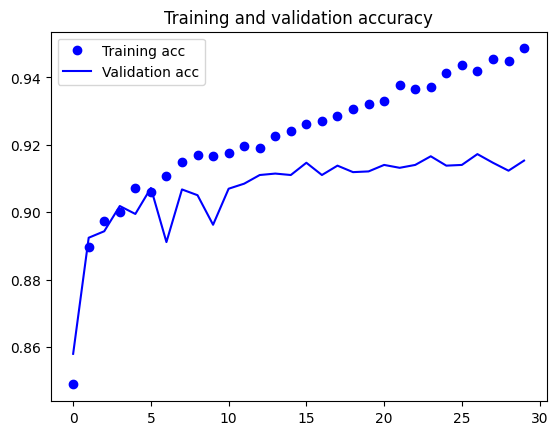

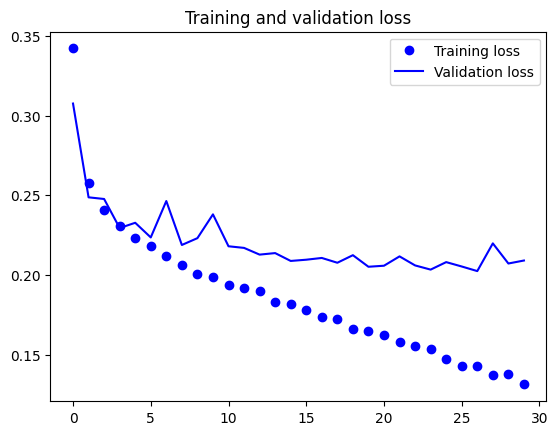

In [11]:
# Plot training and validation accuracy

def plot_training_validation_acc(history, smooth=False, smooth_factor=0.8):
    def smooth_curve(points, factor=0.8):
        smoothed_points = []
        for point in points:
            if smoothed_points:
                previous = smoothed_points[-1]
                smoothed_points.append(previous * factor + point * (1 - factor))
            else:
                smoothed_points.append(point)
        return smoothed_points

    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    if smooth:
        acc = smooth_curve(acc)
        val_acc = smooth_curve(val_acc)
        loss = smooth_curve(loss)
        val_loss = smooth_curve(val_loss)

    epochs = range(len(acc))

    plt.plot(epochs, acc, 'bo', label='Training acc')
    plt.plot(epochs, val_acc, 'b', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()

    plt.figure()

    plt.plot(epochs, loss, 'bo', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

    plt.show()
    
    
plot_training_validation_acc(history)

We get pretty good validation accuracy, especially with such a small dataset, but there seems to be some overfitting.

# Fine tuning with Data Augmentation

- To improve our classifier, we can place it on top of VGG, "unfreeze" the last convolutional block of VGG, then continue training with augmented samples from our dataset.

- This will "fine tune" the last block in VGG, tweaking it to our domain, as well as continuing to train the classifier.

- It is necessary to pre-train the classifier. If we were to place randomly initialized layers on top, large gradient updates would wreck the learned weights in the block we are fine tuning.


In [12]:
%%time

#
# Fine tune top convolutional block, with augmentation
#

print('Building combined model...')
# note that it is necessary to start with a fully-trained
# classifier, in order to successfully do fine-tuning

# Optionally load in the previously trained model to save time
# top_model.load_weights(top_model_weights_path)
# top_model.load('models/cat_dog_full')

# add the model on top of the convolutional base
model = tf.keras.Model(inputs=base_model.input,
              outputs=top_model(base_model.output))



# now let's fine tune one layer within VGG
# Freeze all blocks up to block5 (the block we are fine tuning)
set_trainable = False
for layer in base_model.layers:
    # go through each layer sequentially
    # and start training after block 5
    if layer.name == 'block5_conv1':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False
        
    
# compile the model with a SGD/momentum optimizer
# and a very slow learning rate.
model.compile(loss='binary_crossentropy',
              optimizer=tf.keras.optimizers.SGD(learning_rate=1e-4, momentum=0.9),
              metrics=['accuracy'])

model.summary()




Building combined model...
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 normalizer (Sequential)     (None, 150, 150, 3)       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 150, 150, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 150, 150, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 75, 75, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 75, 75, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None

In [13]:
epochs = 30

checkpoint_filepath = 'models/checkpoint'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

print('Fine tuning combined model...')
history = model.fit(train_ds,
              epochs=epochs,
              batch_size=batch_size,
              callbacks=[model_checkpoint_callback],
              validation_data=val_ds,
              verbose=1)

Fine tuning combined model...
Epoch 1/30


2023-01-24 23:25:27.155283: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


293/293 [==============================] - ETA: 0s - loss: 0.1230 - accuracy: 0.9517

2023-01-24 23:26:06.525601: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


293/293 [==============================] - 48s 162ms/step - loss: 0.1230 - accuracy: 0.9517 - val_loss: 0.1838 - val_accuracy: 0.9288
Epoch 2/30
293/293 [==============================] - 47s 162ms/step - loss: 0.0951 - accuracy: 0.9630 - val_loss: 0.1787 - val_accuracy: 0.9322
Epoch 3/30
293/293 [==============================] - 47s 160ms/step - loss: 0.0744 - accuracy: 0.9709 - val_loss: 0.1967 - val_accuracy: 0.9318
Epoch 4/30
293/293 [==============================] - 48s 162ms/step - loss: 0.0654 - accuracy: 0.9742 - val_loss: 0.1741 - val_accuracy: 0.9369
Epoch 5/30
293/293 [==============================] - 47s 161ms/step - loss: 0.0550 - accuracy: 0.9806 - val_loss: 0.1717 - val_accuracy: 0.9386
Epoch 6/30
293/293 [==============================] - 47s 161ms/step - loss: 0.0472 - accuracy: 0.9839 - val_loss: 0.1698 - val_accuracy: 0.9384
Epoch 7/30
293/293 [==============================] - 48s 162ms/step - loss: 0.0393 - accuracy: 0.9870 - val_loss: 0.1712 - val_accuracy: 0.9

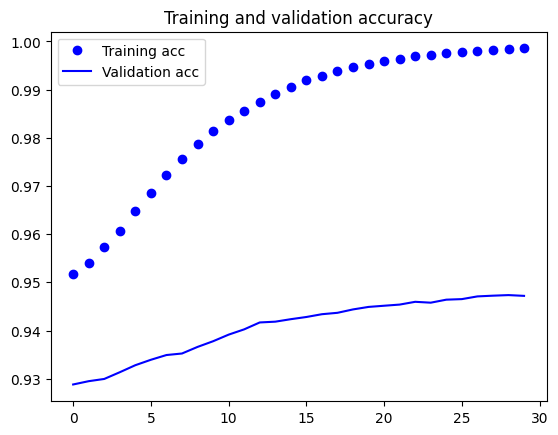

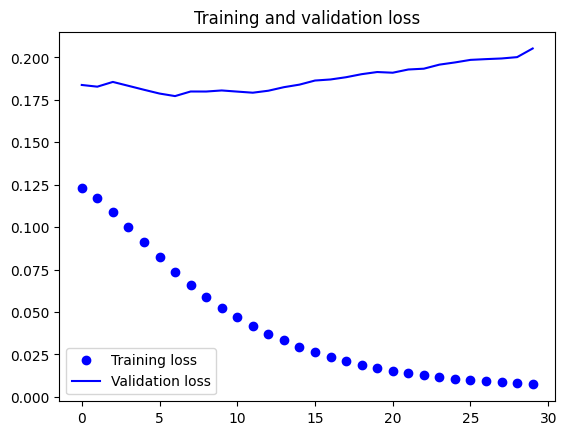

In [14]:
plot_training_validation_acc(history, smooth=True)

In [15]:
test_loss, test_acc = model.evaluate(val_ds)
print('test acc:', test_acc)

74/74 [==============================] - 8s 109ms/step - loss: 0.2256 - accuracy: 0.9465
test acc: 0.9465469121932983


We get an increase in validation accuracy, and there seems to be less overfitting now.

We can plot selected images from the test set and see what the classifier predicted (true label is in parentheses).

2/2 [==============================] - 0s 56ms/step


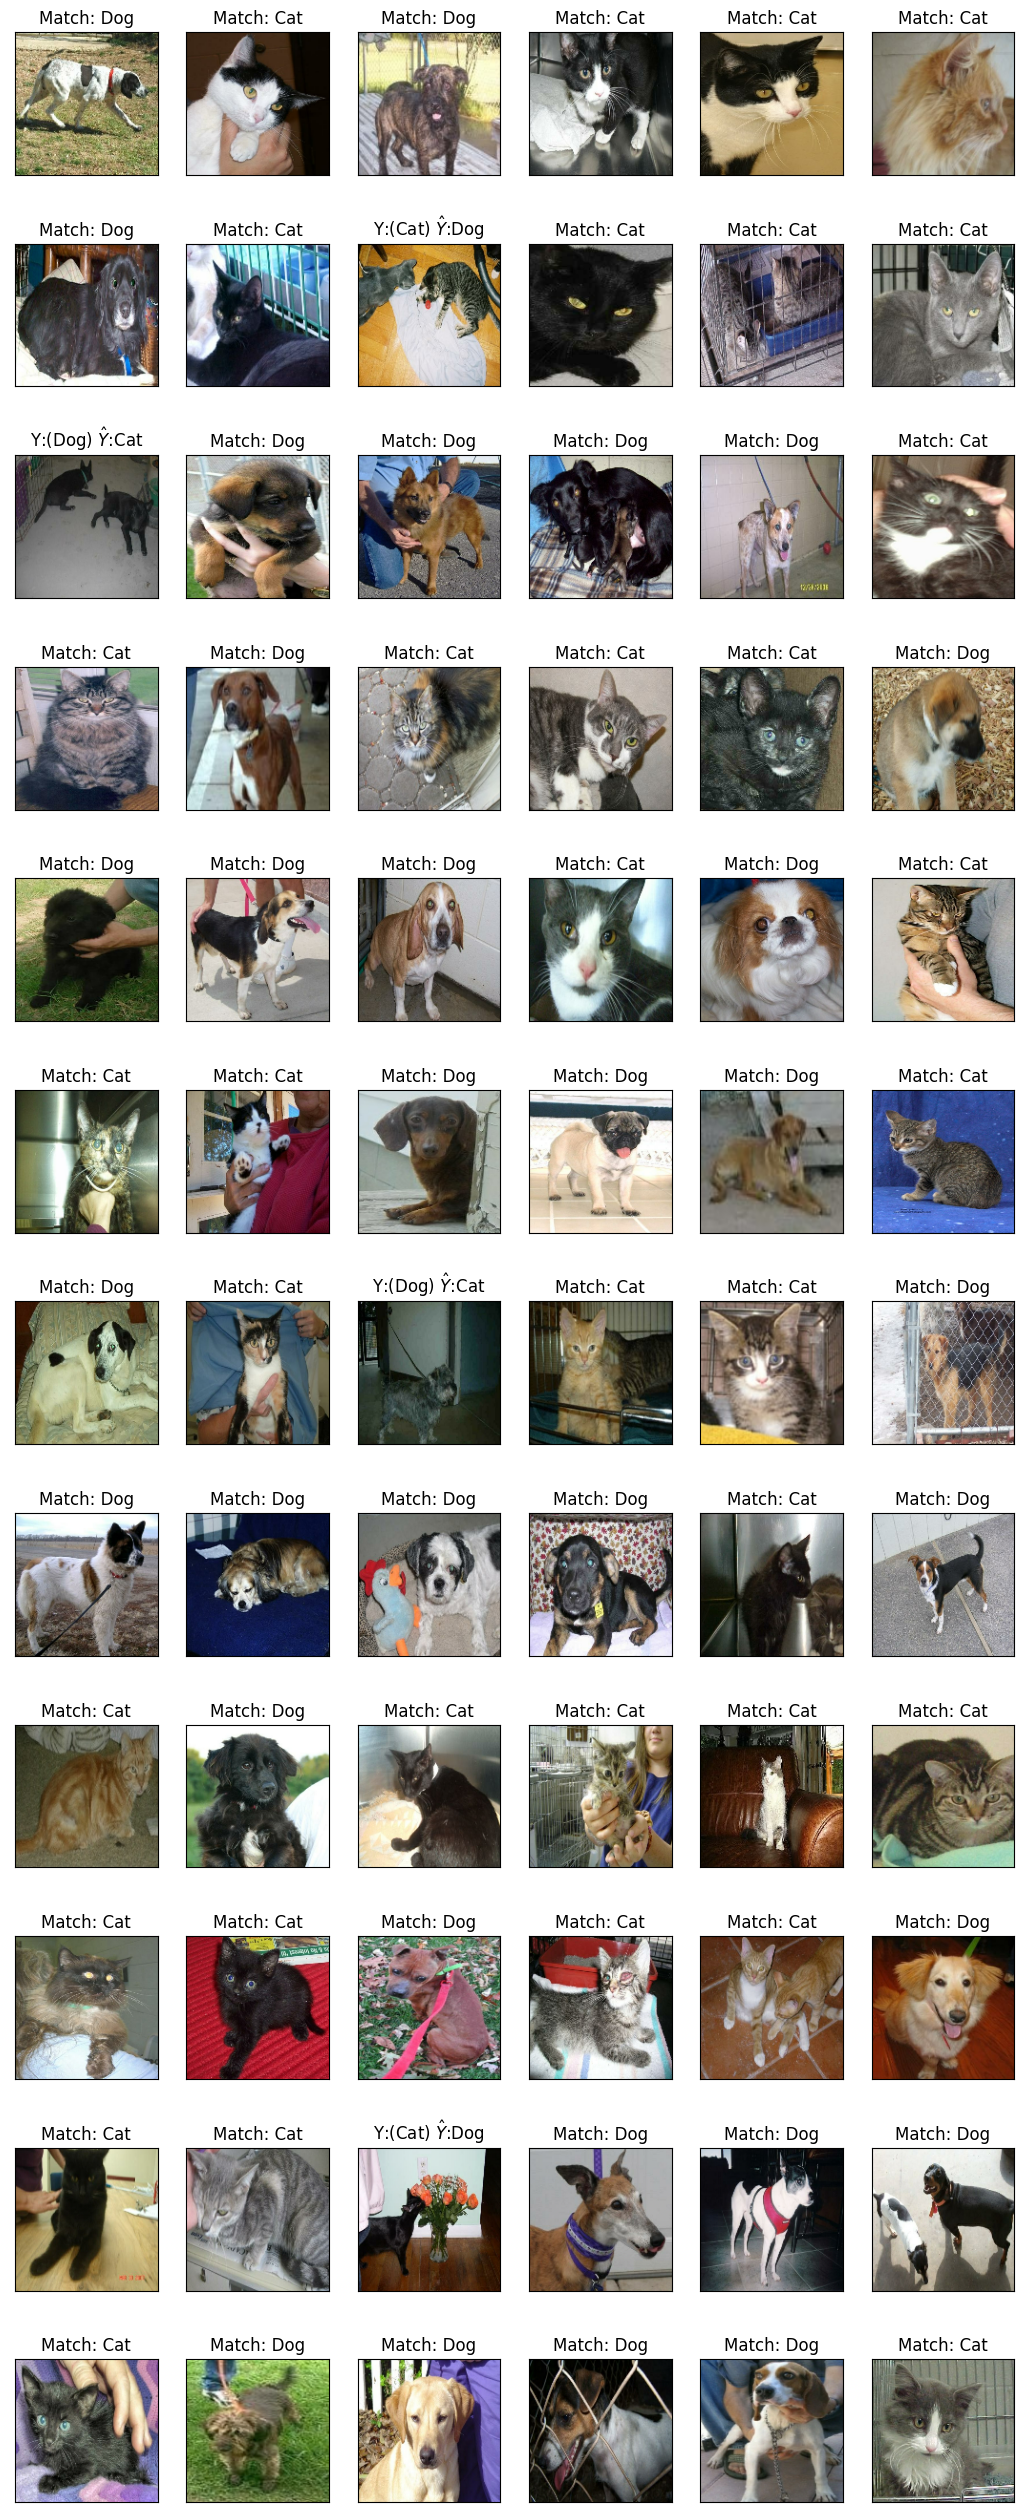

In [19]:
images = []
titles = []

for image, labels in val_ds.take(8):
    y_hat = model.predict(image)
    
    image = [x.numpy().astype("uint8") for x in image]
    images.extend(image)
    labels = ['Dog' if x==1 else 'Cat' for x in labels]
    predictions = ['Dog' if x>0.5 else 'Cat' for x in y_hat]
    tmp = [f'Y:({x}) $\hat Y$:{y}' if x!=y else f'Match: {x}'  for x,y in zip(labels, predictions)]
    
    titles.extend(tmp)

        
plot_gallery(images, titles, n_row=12, n_col=6)

# Conclusion

By fine tuning the last convolutional block, we were able to achieve a slight increase in accuracy. If we were to use data augmentation from the beginning while training our classifier intially by placing the classifier directly on top of VGG instead of saving out the features, the training time would take longer, but we could get a slight increase in accuracy.

In [ ]:
import IPython
url = 'https://storage.googleapis.com/tfjs-examples/webcam-transfer-learning/dist/index.html'
iframe = '<iframe src=' + url + ' width=900 height=700></iframe>'
IPython.display.HTML(iframe)

# References
Info: https://machinelearningmastery.com/transfer-learning-for-deep-learning/

http://ruder.io/transfer-learning

https://www.cse.ust.hk/~qyang/Docs/2009/tkde_transfer_learning.pdf

Image Graph: Suzuki, Masahiro & Sato, Haruhiko & Oyama, Satoshi & Kurihara, Masahito. (2014). Transfer learning based on the observation probability of each attribute. 
Pacman: https://github.com/tensorflow/tfjs-examples/tree/master/webcam-transfer-learning